In [69]:
from parcels import plotTrajectoriesFile
import numpy as np
from netCDF4 import Dataset

from scipy import sparse
import scipy.sparse.linalg as sp_linalg

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

import cartopy.feature as feat
import cartopy.crs as ccrs
import seaborn as sns; sns.set()

import datetime
import pickle as pk
from tqdm.notebook import tqdm


### Functions


In [205]:
def savefig(ddir, filename):
    
    plt.savefig(ddir+filename+".png") # save plot as png-file 
    return print('File successful saved as:', filename)

def extract_data(directory, file):
    R = Dataset(directory+file, 'r')
    
    lons = np.asarray(R['lon'])
    lats = np.asarray(R['lat'])
    lons[lons>180]-=360
    lons[lons<-180]+=360
    
    times = np.asarray(R['time'])
    traj = np.asarray(R['trajectory'])
    
    return lons, lats, times, traj

def nb_particles(longitude):
    n_particles = []

    for i in range(len(longitude)) : 
        p = len(longitude[i])
        n_particles.append(p)

    for nb in n_particles:
        nb_p = print('Total number of particles :', nb)
    
    return n_particles

def draw_map(P_AB, lon_s, lat_s, title, ddir, filename, proj = ccrs.PlateCarree(), extent = [27,42,40.8,48],
            minlon = 27, maxlon = 42, minlat = 41, maxlat = 48, spacing = 0.1, vmin = 0, vmax = 1, 
            cmap = sns.cubehelix_palette(n_colors = 10, start = 3, rot = -1, gamma = 0.8, hue = 1, 
                                          light = 0.95, dark = 0., reverse = False, as_cmap = True)):
    
    fig = plt.figure (figsize = (20, 20))  
    m1 = fig.add_subplot(111, projection = ccrs.PlateCarree()) 
    m1.set_extent(extent)

    """ gl= m1.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, 
                  linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.ylabels_right=False
    gl.xlabels_bottom = True
    gl.ylabel_style = {'weight': 'bold', 'size' : 13.5}
    gl.xlabel_style = {'weight': 'bold', 'size': 13.5}"""


    lon = np.arange(minlon,maxlon,spacing)
    lat = np.arange(minlat,maxlat,spacing)
    Lat, Lon = np.meshgrid(lat, lon)
  
    p = m1.pcolormesh(Lon, Lat, P_AB, cmap = cmap, vmin = vmin , vmax = vmax)                   
    
    m1.scatter(lon_s,lat_s, c = 'red', zorder = 150, s = 150)
    
    dataLon = [29.095901,29.251028,29.42017644,29.61114644,29.80004478,30.11045977,30.416189,30.29077978,
              30.157995,30.042621]
    dataLat = [44.248336,44.328443,44.43146465,44.53782797,44.62338299,44.78907964,44.956317,44.99534464,
               45.033776,45.06459]
    
    label = ['1','2','3','4','5','6','7','8','9','10']
    
    #Add river location
    """for lon, lat, name in zip(dataLon, dataLat, label):
        m1.text(lon - 0.02, lat -0.095, str(name), fontsize=20, weight = 'bold', 
                color='red',transform=ccrs.PlateCarree())"""
    
    m1.scatter(dataLon, dataLat, c = 'red', marker = 'X',  s= 100)


    land_10m = feat.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',
                                       facecolor = 'floralwhite')

    m1.add_feature(land_10m)
    m1.coastlines('10m')

    plt.title(title, size=25)

    cbar=fig.colorbar(p, shrink = 0.35,extend = 'both',pad = 0.01)
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'Probability',size=20, labelpad = 18)    
    
    m1.text(-0.045, 0.5, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=m1.transAxes, fontsize = 19)
    m1.text(0.5, -0.1, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=m1.transAxes, fontsize = 19)


    savefig(ddir, filename)
    
    
    return p
    
    
def P_loc_source(density, n_particle_source):
    
    normalizer = np.ones([density.shape[0],density.shape[1]])*n_particle_source
    
    P_BA = density/normalizer
    
    P_BA = np.array(P_BA)
    
    return P_BA

def P_loc(density_all, n_particle_all, P_source_all):
    
    """
    Calculate the sum of all the prior probabilities :
    - P(B) = $sum_{i,j = 0}^{i,j = n} P(B_j|PA_i)P(A_i)$
    - density_all : list containing the densities after advection of each source
    - n_particles_tot : array containing total nb of particles advected for each source
    - P_source_all : array containing the probability of each source
    """
    
    P_B_tmp = []

    for i, _ in enumerate(density_all):
        P_B_tmp2 = (density_all[i]/n_particle_all[i])*P_source_all[i]
        P_B_tmp.append(P_B_tmp2)

    P_B_tmp = np.array(P_B_tmp)

    P_B = np.sum(P_B_tmp, axis = 0) 
    
    return P_B


def P_source_loc(density, P_source, n_particle_source, P_B):
    """
    Calculate the probability that a particle from a grid-cell B_j comes from a source A_i :
    - Bayes Theorem : $P(A_i|B_j) = P(B_j|A_i)P(A)/P(B)$
    - density : particles density after advection from the source (e.g., Danube simulation) (P(B|A))
    - P_source : probability of the source (P(A))
    - n_particles_source : total nb of particles advected from the source
    
    """
    
    P_A = np.ones([density.shape[0],density.shape[1]])*P_source
    
    P_BA = P_loc_source(density, n_particle_source)
    
    P_AB_tmp = P_BA*P_A
        
    P_AB_tmp = np.array(P_AB_tmp)

    P_AB = P_AB_tmp/P_B

    return P_AB


### Load Data

In [78]:


ddir = r'C:\Users\Administrateur\Documents\CP_18-20\Thesis\Parcels\Rivers'
files = ['\Density_6\Danube6',
         '\Density_8\Dniepr8',
         '\Density_6\Rioni6',
         '\Density_6\Dniester6',
         '\Density_6\Coruh6',
         '\Density_6\Kizilirmak6',
         '\Density_6\Sakarya6',
         '\Density_6\Yesilimark6',
         '\Density_6\Kodori6',
         '\Density_6\Bzyb6'
        ]

ddir2 = r'C:\Users\Administrateur\Documents\CP_18-20\Thesis\Parcels\Rivers'
files2 = ['\RUN_DANUBE6_365d.nc',
          '\RUN_DNIEPR8_365d.nc',
          '\RUN_RIONI6_365d.nc',
          '\RUN_DNIESTER6_365d.nc',
          '\RUN_CORUH6_365d.nc',
          '\RUN_KIZILIRMAK6_365d.nc',
          '\RUN_SAKARYA6_365d.nc',
          '\RUN_YESILIMARK6_365d.nc',
          '\RUN_KODORI6_365d.nc',
          '\RUN_BZYB6_365d.nc'
         ]

dsty_tmp = []

for f in files : 
    Dsty = pk.load(open(ddir+f, 'rb'))
    dsty_tmp.append(Dsty)

for i in range(len(dsty_tmp)):
    dsty_tmp[i][np.isnan(dsty_tmp[i])]=0 


lon, lat, time,traj = [[] for i in range (4)]

for f2 in files2 : 
    lo,la,t,tra = extract_data(ddir2, f2)
    lon.append(lo)
    lat.append(la)
    time.append(t)
    traj.append(tra)

n_particles = nb_particles(lon)

dsty = [np.mean(dsty_tmp[i], axis = 0) for i in range(len(dsty_tmp))]


C:\Anaconda3\envs\py3_parcels\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda3\envs\py3_parcels\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


Total number of particles : 24156
Total number of particles : 8418
Total number of particles : 1464
Total number of particles : 1098
Total number of particles : 1098
Total number of particles : 732
Total number of particles : 732
Total number of particles : 732
Total number of particles : 366
Total number of particles : 366


# Bayes Theorem : 

$P(A_i|B_j) = \frac{P(B_j|A_i)P(A)}{P(B)}$,

with 

$P(B) = \sum_{i,j = 0}^{i,j = n} P(B_j|PA_i)P(A_i)$



In [108]:
"""
Order:
1. Danube
2. Dniepr
3. Rioni
4. Dniester
5. Coruh
6. Kizilirmak
7. Sakarya
8. Yesilimark
9. Kodori
10. Bzyb
"""

outdir = r'C:\Users\Administrateur\Documents\CP_18-20\Thesis\Figure\Bayes'



lat_s = [45.221998, 46.511751,
         42.183748, 
         46.081485, 41.608372, 
         41.754870 , 41.136737,
         41.386579, 42.819377, 43.184802]
        

lon_s = [29.7, 32.271580, 
         41.634994, 
         30.494232, 41.560132, 
         35.955972, 30.650267,
         36.661469, 41.129852, 40.277446
        ]

#P_source = P(B) from litterature 
#here:the water discharge of each rivers in % relative to the total freshwater discharge in the Black Sea
P_source = [66.5, 15.3, 4.2, 3.4, 2.8, 1.8, 1.9, 1.7, 1.3, 1.1] 


P_source = np.array(P_source)

t = 'Bayes inference (1y mean):'
titles = [t + 'Danube', t + 'Dniepr', 
          t + 'Rioni', 
          t + 'Dniester', t + 'Coruh', 
         t+ 'Kizilirmak', t + 'Sakarya', t + 'Yesilimark', 
         t + 'Kodori', t + 'Bzyb']
         

outnames = ['\Bayes_Danube8', '\Bayes_Dniepr8',
            '\Bayes_Rioni8', 
            '\Bayes_Dniester8', '\Bayes_Coruh8', 
            '\Bayes_Kizilirmak8', '\Bayes_Sakarya8',
           '\Bayes_Yesilimark8', '\Bayes_Kodori8', '\Bayes_Bzyb8']
           

assert len(dsty) == len(n_particles) == len(lat_s) == len(lon_s) == len(P_source) == len(titles)

assert sum(P_source)==1


### Calculating P(A|B)

In [157]:
P_B = P_loc(dsty, n_particles, P_source)

P_AB = []

for i in range(len(dsty)):
    P_AB_tmp1 = P_source_loc(dsty[i],P_source[i], n_particles[i], P_B)
    P_AB.append(P_AB_tmp1)


C:\Anaconda3\envs\py3_parcels\lib\site-packages\ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in true_divide


### Plots

File successful saved as: \example1


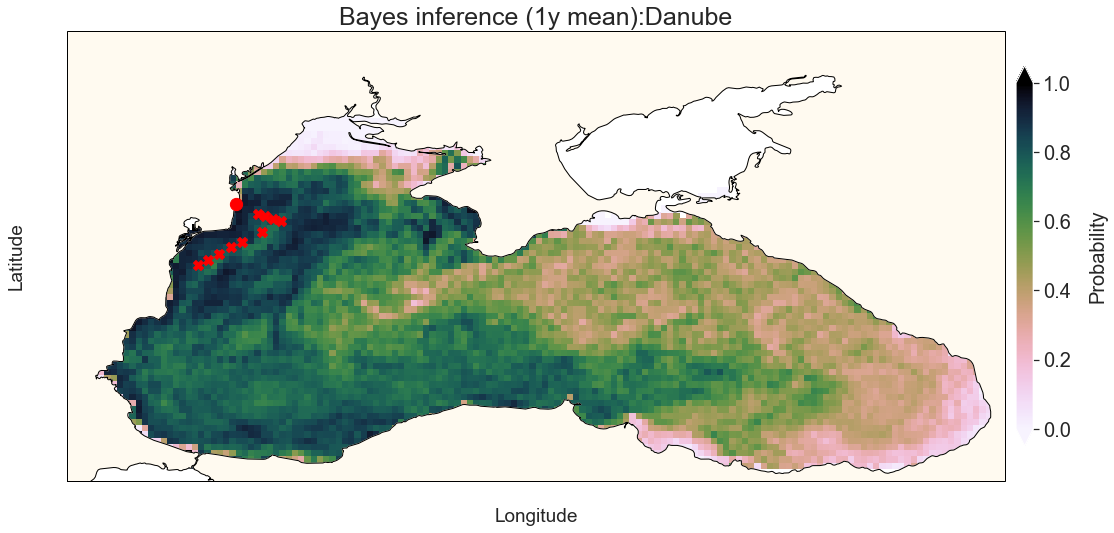

In [206]:
p2 = draw_map(P_AB[0],lon_s[0], lat_s[0], titles[0], outdir, '\example1')


### Testing if all the probabilities sum up to 1


File successful saved as: \Test7
The probabilities vary from 	0.0	to 	1.0000000000000004


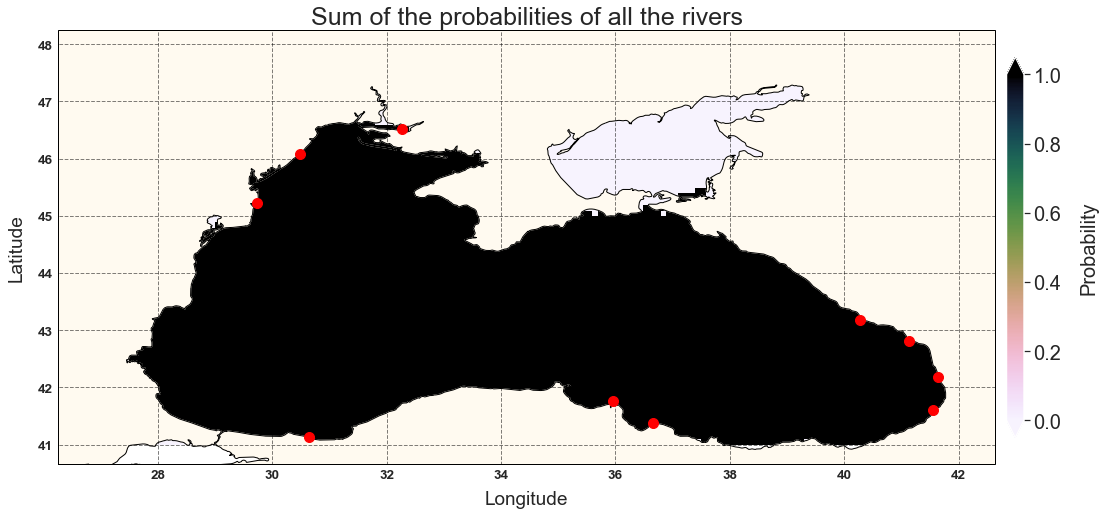

In [68]:
P_AB = np.array(P_AB)

test = np.sum(P_AB,axis=0)

test = np.array(test)

draw_map(test,lon_s, lat_s, 'Sum of the probabilities of all the rivers', outdir, '\Test7')
#plt.close()

maximum = [max(test[i]) for i in range(test.shape[0])]
max(maximum)

minimum = [min(test[i]) for i in range(test.shape[0])]

print('The probabilities vary from \t' + str(min(minimum)) + '\t' + 'to \t' + str(max(maximum)))